# LeNet-5 with SVD
Author : Satrya Budi Pratama

In [213]:
import gzip
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import time

## Load Dataset

In [2]:
def read_mnist(images_path, labels_path):
    """
        This method load extracted file of MNIST
        input : images_path,labels_path
        return : features, labels
    """
    
    with gzip.open(labels_path, 'rb') as labelsFile:
        labels = np.frombuffer(labelsFile.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path,'rb') as imagesFile:
        length = len(labels)
        # Load flat 28x28 px images (784 px), and convert them to 28x28 px
        features = np.frombuffer(imagesFile.read(), dtype=np.uint8, offset=16) \
                        .reshape(length, 784) \
                        .reshape(length, 28, 28, 1)
        
    return features, labels

### Training Data

In [3]:
data_train = {}
data_train_filename = "MNIST Dataset/train-images-idx3-ubyte.gz"
data_train_label_filename = "MNIST Dataset/train-labels-idx1-ubyte.gz"
data_train['X'], data_train['y'] = read_mnist(data_train_filename,data_train_label_filename)

### Testing Data

In [4]:
data_test = {}
data_test_filename = "MNIST Dataset/t10k-images-idx3-ubyte.gz"
data_test_label_filename = "MNIST Dataset/t10k-labels-idx1-ubyte.gz"
data_test['X'], data_test['y'] = read_mnist(data_test_filename, data_test_label_filename)

## Display Images

In [5]:
def display_image(position):
    image = data_train['X'][position].squeeze()
    plt.title('Example %d. Label: %d' % (position, data_train['y'][position]))
    plt.imshow(image, cmap=plt.cm.gray_r)

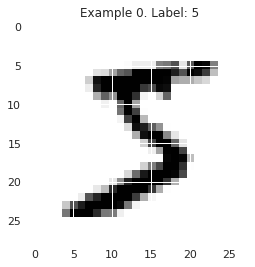

In [6]:
display_image(0)

## Observe the training data

In [7]:
train_labels_count = np.unique(data_train['y'], return_counts=True)
dataframe_train_labels = pd.DataFrame({'Label':train_labels_count[0], 'Count':train_labels_count[1]})
dataframe_train_labels

,Label,Count
0,0,5923
1,1,6742
2,2,5958
3,3,6131
4,4,5842
5,5,5421
6,6,5918
7,7,6265
8,8,5851
9,9,5949


The train data is balance for each class, it's good for a dataset to build a good model

## Shuffle and split the training data into training and validation

Shuffling and splitting our training data into 2 sets: train and validation. While leaving the test data unseen by our model until we are done with the training to avoid a self-fulfilling prophecy.

In [8]:
# shuffle
data_train['X'], data_train['y'] = shuffle(data_train['X'], data_train['y'])

In [9]:
# split into train and validation, 20% of validation data and 80% of training data
data_validation = {}
data_train['X'], data_validation['X'], data_train['y'], data_validation['y'] = train_test_split(data_train['X'], data_train['y'], test_size=0.2, random_state=0)

In [10]:
# check number of data train
len(data_train['X'])

48000

In [11]:
# check number of validation
len(data_validation['X'])

12000

## Prepare Input Images 
The LeNet architecture accepts a 32x32 pixel images as input, mnist data is 28x28 pixels. We simply pad the images with zeros to overcome that.

In [12]:
# Pad images with 0s
data_train['X']      = np.pad(data_train['X'], ((0,0),(2,2),(2,2),(0,0)), 'constant')
data_validation['X'] = np.pad(data_validation['X'], ((0,0),(2,2),(2,2),(0,0)), 'constant')
data_test['X']       = np.pad(data_test['X'], ((0,0),(2,2),(2,2),(0,0)), 'constant')
    
print("Updated Image Shape: {}".format(data_train['X'][0].shape))

Updated Image Shape: (32, 32, 1)


## LeNet-5 Implementation

In [117]:
# parameters
EPOCHS = 12
BATCH_SIZE = 128
n_classes = 10
learning_rate = 0.0002

In [31]:
# Importing the required Keras modules containing model and layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, AveragePooling2D

model = Sequential()

model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,1)))
model.add(AveragePooling2D())

model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(AveragePooling2D())

model.add(Flatten())

model.add(Dense(units=120, activation='relu'))

model.add(Dense(units=84, activation='relu'))

model.add(Dropout(0.2))

model.add(Dense(units=10, activation = 'softmax'))

## Training Model without SVD

In [175]:
from keras.optimizers import Adam
optimizer = Adam(lr=learning_rate)
model.compile(optimizer= optimizer, 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
original = model.fit(x=data_train['X'],y=data_train['y'], epochs=EPOCHS,  
                    # We pass some validation for
                    # monitoring validation loss and metrics
                    # at the end of each epoch
                    validation_data=(data_validation['X'], data_validation['y']))

Train on 48000 samples, validate on 12000 samples
Epoch 1/12
48000/48000 [==============================] - 26s 538us/step - loss: 0.0017 - accuracy: 0.9994 - val_loss: 0.0801 - val_accuracy: 0.9902
Epoch 2/12
48000/48000 [==============================] - 27s 560us/step - loss: 0.0025 - accuracy: 0.9994 - val_loss: 0.0830 - val_accuracy: 0.9897
Epoch 3/12
48000/48000 [==============================] - 26s 540us/step - loss: 0.0023 - accuracy: 0.9992 - val_loss: 0.0691 - val_accuracy: 0.9905
Epoch 4/12
48000/48000 [==============================] - 26s 550us/step - loss: 0.0031 - accuracy: 0.9990 - val_loss: 0.0785 - val_accuracy: 0.9898
Epoch 5/12
48000/48000 [==============================] - 26s 546us/step - loss: 0.0018 - accuracy: 0.9995 - val_loss: 0.0813 - val_accuracy: 0.9899
Epoch 6/12
48000/48000 [==============================] - 26s 549us/step - loss: 0.0018 - accuracy: 0.9995 - val_loss: 0.0868 - val_accuracy: 0.9895
Epoch 7/12
48000/48000 [==============================] 

### Visualize the training process performance

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


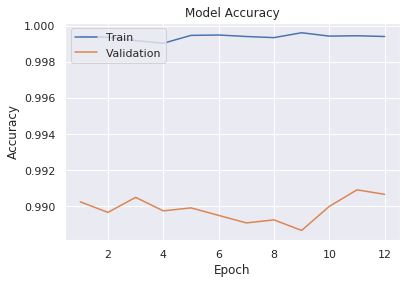

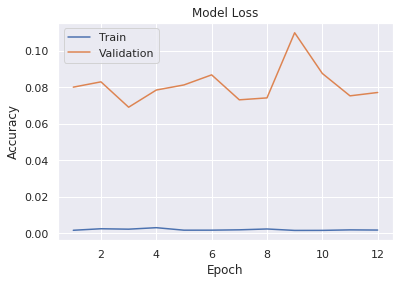

In [189]:
# Plot data
# list all data in history
print(original.history.keys())
# summarize history for accuracy
x_axis = np.arange(1,EPOCHS+1)
plt.plot(x_axis,original.history['accuracy'])
plt.plot(x_axis,original.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(x_axis,original.history['loss'])
plt.plot(x_axis,original.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Testing Model without SVD

In [206]:
test_result = model.evaluate(data_test['X'], data_test['y'])
print("Model Loss : {:.4f} - Accuracy : {:.4f}".format(test_result[0],test_result[1]))

10000/10000 [==============================] - 2s 236us/step
Model Loss : 0.0772 - Accuracy : 0.9912


## SVD Implementation

In [159]:
def get_reduced_data(features, number_of_components):
    """
    This method process all original data to low rank data using SVD, and reconstruct using some components.
    Result of the dimension of features is same, so no dimension reduction but keep the data lower.
    Input : features , number_of_components
    Output : reduced_features
    """
    
    reduced_features = []
    # iterate over features
    for i in range(len(features)):
        # obtain svd without the channel 32x32xC
        U, S, V = np.linalg.svd(features[i].squeeze())
        # construct the matrix to lower rank
        reduced_feature = U[:, :number_of_components] @ np.diag(S[:number_of_components]) @ V[:number_of_components , :]
        # append to the list and add channel again so 32x32x1
        reduced_features.append(reduced_feature[:,:,np.newaxis]) 
    
    return np.array(reduced_features) # convert from list to array

### Visualize the Image from reduced data

In [140]:
# components that we use, less than the original dimension
num_of_components = 15

# get SVD
U, S, V = np.linalg.svd(data_train['X'][0].squeeze())
# reconstruct the matrix to low rank matrix with 15 components 
low_rank = U[:, :num_of_components] @ np.diag(S[:num_of_components]) @ V[:num_of_components, :]
low_rank

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

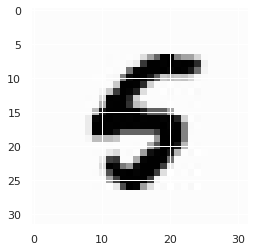

In [141]:
# show images
plt.imshow(low_rank.squeeze(), cmap=plt.cm.gray_r)

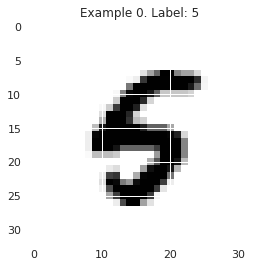

In [142]:
# original image
display_image(0)

### Get reduced data for Data Training, Data Validation, and Data Testing

In [174]:
data_train_SVD = get_reduced_data(data_train['X'], num_of_components)
data_test_SVD = get_reduced_data(data_test['X'], num_of_components)
data_validation_SVD = get_reduced_data(data_validation['X'], num_of_components)

## Training Model with SVD

In [199]:
model_svd = model.fit(x=data_train_SVD,y=data_train['y'], epochs=EPOCHS,  
                    # We pass some validation for
                    # monitoring validation loss and metrics
                    # at the end of each epoch
                    validation_data=(data_validation_SVD, data_validation['y']))

Train on 48000 samples, validate on 12000 samples
Epoch 1/12
48000/48000 [==============================] - 27s 568us/step - loss: 0.0026 - accuracy: 0.9992 - val_loss: 0.0841 - val_accuracy: 0.9895
Epoch 2/12
48000/48000 [==============================] - 28s 575us/step - loss: 0.0012 - accuracy: 0.9996 - val_loss: 0.0717 - val_accuracy: 0.9906
Epoch 3/12
48000/48000 [==============================] - 27s 558us/step - loss: 0.0026 - accuracy: 0.9993 - val_loss: 0.0645 - val_accuracy: 0.9913
Epoch 4/12
48000/48000 [==============================] - 27s 556us/step - loss: 0.0017 - accuracy: 0.9996 - val_loss: 0.0747 - val_accuracy: 0.9907
Epoch 5/12
48000/48000 [==============================] - 27s 569us/step - loss: 0.0011 - accuracy: 0.9996 - val_loss: 0.0855 - val_accuracy: 0.9902
Epoch 6/12
48000/48000 [==============================] - 29s 596us/step - loss: 0.0033 - accuracy: 0.9990 - val_loss: 0.0758 - val_accuracy: 0.9915
Epoch 7/12
48000/48000 [==============================] 

### Visualize the training process performance

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


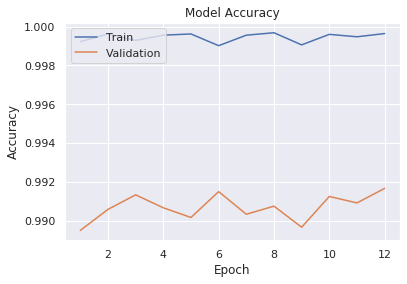

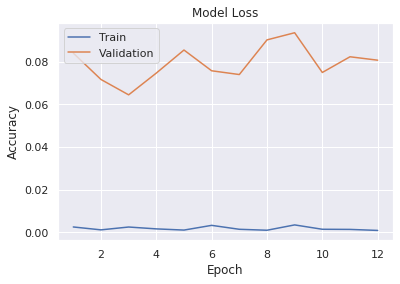

In [200]:
# Plot data
# list all data in history
print(model_svd.history.keys())
# summarize history for accuracy
x_axis = np.arange(1,EPOCHS+1)
plt.plot(x_axis,model_svd.history['accuracy'])
plt.plot(x_axis,model_svd.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(x_axis,model_svd.history['loss'])
plt.plot(x_axis,model_svd.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Testing Model with SVD

In [205]:
test_result = model.evaluate(data_test_SVD, data_test['y'])
print("Model Loss : {:.4f} - Accuracy : {:.4f}".format(test_result[0],test_result[1]))

10000/10000 [==============================] - 2s 242us/step
Model Loss : 0.0769 - Accuracy : 0.9912


## Observe the number of components to test result

In [216]:
acc_test_list = []
required_time_list = []
num_of_components_list = np.arange(2,32,2)
num_of_components_list

array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30])

In [ ]:
for num_components in num_of_components_list:
    print("\n")
    print("SVD Implementation with components {}".format(num_components))
    start_time = time.time()
    print("Preprocessing all data...")
    # pre processing
    data_train_SVD = get_reduced_data(data_train['X'], num_components)
    data_test_SVD = get_reduced_data(data_test['X'], num_components)
    data_validation_SVD = get_reduced_data(data_validation['X'], num_components)
    print("Training model...")
    # training
    model.fit(x=data_train_SVD,y=data_train['y'], epochs=EPOCHS,  
                    # We pass some validation for
                    # monitoring validation loss and metrics
                    # at the end of each epoch
                    validation_data=(data_validation_SVD, data_validation['y']))
    
    print("Testing model...")
    # testing
    test_result = model.evaluate(data_test_SVD, data_test['y'])
    print("Model Loss : {:.4f} - Accuracy : {:.4f}".format(test_result[0],test_result[1]))
    required_time = time.time() - start_time
    print("--- %s seconds ---" % (required_time))
    acc_test_list.append(test_result[1]) # append accuracy result to list
    required_time_list.append(required_time)
    



SVD Implementation with components 2
Preprocessing all data...
Training model...
Train on 48000 samples, validate on 12000 samples
Epoch 1/12
48000/48000 [==============================] - 27s 557us/step - loss: 0.0905 - accuracy: 0.9714 - val_loss: 0.1231 - val_accuracy: 0.9663
Epoch 2/12
48000/48000 [==============================] - 26s 550us/step - loss: 0.0695 - accuracy: 0.9771 - val_loss: 0.1245 - val_accuracy: 0.9682
Epoch 3/12
48000/48000 [==============================] - 27s 569us/step - loss: 0.0591 - accuracy: 0.9805 - val_loss: 0.1212 - val_accuracy: 0.9712
Epoch 4/12
48000/48000 [==============================] - 27s 567us/step - loss: 0.0475 - accuracy: 0.9839 - val_loss: 0.1132 - val_accuracy: 0.9725
Epoch 5/12
48000/48000 [==============================] - 29s 599us/step - loss: 0.0409 - accuracy: 0.9864 - val_loss: 0.1259 - val_accuracy: 0.9721
Epoch 6/12
48000/48000 [==============================] - 28s 588us/step - loss: 0.0350 - accuracy: 0.9879 - val_loss: 0.1

In [ ]:
plt.plot(num_of_components_list,acc_test_list)

In [ ]:
start = time.process_time()
start